In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
training_data = loadtxt(f"data_all.csv", delimiter=',')
training_data

array([[42.738, 20.028, 37.234, 78.202, 1.747, 464.793, 48.990, -6.730],
       [35.410, 63.615, 0.975, 72.708, 4.089, 128.993, 25.616, -43.130],
       [38.607, 31.172, 30.221, 66.877, 2.993, 91.991, 29.951, -17.330],
       [70.546, 21.700, 7.754, 71.495, 0.604, 147.951, 64.000, 7.760],
       [32.484, 47.606, 19.910, 62.353, 4.338, 268.694, 23.035, -32.220],
       [2.183, 47.834, 49.983, 60.888, 0.193, 227.405, 0.921, -42.530],
       [26.227, 3.214, 70.558, 73.616, 1.308, 298.860, 42.261, 12.760],
       [46.493, 8.374, 45.133, 65.425, 3.356, 41.452, 58.352, 13.640],
       [27.885, 56.712, 15.403, 69.485, 0.953, 351.240, 17.621, -38.710],
       [27.256, 28.335, 44.409, 64.019, 2.528, 381.236, 19.403, -24.740],
       [26.061, 39.625, 34.314, 78.693, 4.944, 438.393, 19.361, -30.650],
       [7.099, 50.405, 42.496, 75.713, 2.373, 198.215, 4.816, -41.710],
       [10.602, 33.869, 55.529, 69.391, 0.053, 82.476, 8.869, -32.170],
       [35.819, 10.306, 53.875, 69.788, 4.931, 126.998,

In [27]:
from sklearn.metrics import r2_score, mean_squared_error

In [42]:
####################
# initialization

n_var = 6
n_obj = 2

random_state = 42
torch.manual_seed(random_state) # gives a consistent seed based on the trial number

ref_point = torch.tensor([-50, 0], **tkwargs)
hv=Hypervolume(ref_point=ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

lower_bounds = torch.tensor([5.0, 5.0, 5.0, 60, 0.01, 60.0], **tkwargs) 
upper_bounds = torch.tensor([95.0, 95.0, 95.0, 80, 5.0, 480.0], **tkwargs)
problem_bounds = torch.vstack([lower_bounds, upper_bounds])

standard_bounds = torch.zeros(2, n_var, **tkwargs)
standard_bounds[1] = 1

BATCH_SIZE = 12
BATCH_NUM = np.concatenate([np.repeat(1, 27), np.repeat(2, 12), np.repeat(3, 16), np.repeat(4, 20), np.repeat(5, 14)])
batch_list = [26, 39, 55, 75, 89]

In [43]:
r2_list1, r2_list2 = [], []
mse_list1, mse_list2 = [], []

for finish in batch_list:
    # set the tensor according to latest cumulative dataset
    train_x = torch.tensor(training_data[:finish,:n_var], **tkwargs)
    train_obj = torch.tensor(training_data[:finish,n_var:n_var+n_obj], **tkwargs)

    # we need to do some scaling for the outputs
    # output 1 for styrene% should be converted to negative to force minimization
    # output 2 for TG needs to be scaled to ensure maximization
    train_obj[:,0] = -train_obj[:,0]
    output_lower = train_obj[:,1].min()
    output_upper = train_obj[:,1].max()
    output_bounds = torch.vstack([output_lower, output_upper])
    train_obj[:,1] = normalize(train_obj[:,1], output_bounds)
    
    ####################
    # surrogate model

    train_x_gp = normalize(train_x, problem_bounds)

    # form the output train_y data by concentenating train_obj with train_con 
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    #train_y = torch.cat([train_obj, train_con], dim=-1)
    train_y = train_obj

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model1 = ModelListGP(*models)
    mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

    fit_gpytorch_model(mll1) 

    model1.eval()

    with torch.no_grad():
        y_true = train_y
        posterior = model1.posterior(train_x_gp)  
        y_pred = posterior.mean.squeeze()
        lower, upper = posterior.mvn.confidence_region()
        
    
    for i, r2list, mselist in zip([0,1],
                                  [r2_list1,r2_list2],
                                  [mse_list1, mse_list2]
                           ):
        
        mid_score = r2_score(train_y[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        r2list.append(mid_score)

        mid_score = mean_squared_error(train_y[:,i].cpu().numpy(), y_pred[:,i].cpu().numpy())
        mselist.append(mid_score)

C:\Users\user\anaconda3\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\user\anaconda3\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\user\anaconda3\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\user\anaconda3\lib\site-packages\botorch\models\utils\assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
C:\Users\user\anaconda3\lib\site-packages\botorch\models\utils\assorted.py:1

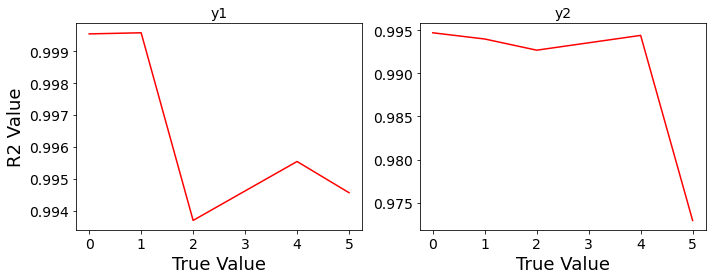

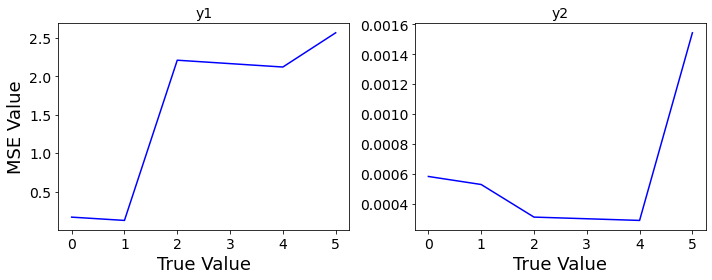

In [44]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,4))

for i, obj, r2list in zip([0,1], ["y1", 'y2'], [r2_list1, r2_list2]):

        ax[i].plot([0,1,2,4,5], r2list, c='r',)

        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')

ax[0].set_ylabel('R2 Value')
fig.tight_layout()

fig, ax = plt.subplots(ncols = 2, figsize = (10,4))

for i, obj, mselist in zip([0,1], ["y1", 'y2'], [mse_list1, mse_list2]):

        ax[i].plot([0,1,2,4,5], mselist, c='b',)

        ax[i].set_title(obj)
        ax[i].set_xlabel('True Value')

ax[0].set_ylabel('MSE Value')
fig.tight_layout()